In [23]:
import pandas as pd
import pandas_ta as ta
from tqdm import tqdm
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from datetime import datetime
from backtesting import Strategy
from backtesting import Backtest
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

tqdm.pandas()


def read_data(symbol, period, interval):
    data = pd.read_csv(f'../data/{symbol}-{period}-{interval}.csv')
    data.Datetime = pd.to_datetime(data.Datetime, utc=True)
    data.set_index('Datetime', inplace=False)
    data.drop(['Dividends', 'Stock Splits', 'Volume'], axis=1, inplace=True)
    return data


def set_ema(data, ema_length):
    data['EMA'] = ta.ema(data.Close, length=ema_length)
    return data


def set_macd(data):
    macd = ta.macd(data.Close)
    data['MACD'] = macd.loc[:, 'MACD_12_26_9']
    data['MACD_signal'] = macd.loc[:, 'MACDs_12_26_9']
    data['MACD_histogram'] = macd.loc[:, 'MACDh_12_26_9']
    return data


def set_atr(data):
    data['ATR'] = ta.atr(data.High, data.Low, data.Close, length=7)
    return data

def set_rsi(data, rsi_length):
    data['RSI'] = ta.rsi(data.Close, length=rsi_length)
    return data

def set_adx(data, length):
    adx = ta.adx(data['High'], data['Low'], data['Close'], length=length)
    data['ADX'] = adx.ADX_14
    data['ADX_pos'] = adx.DMP_14
    data['ADX_neg'] = adx.DMN_14
    return data

def ema_trade_signal(data, current, back_candles):
    start = max(0, current - back_candles)
    rows = data.loc[start:current]

    if all(rows.High < rows.EMA):
        return -1
    elif all(rows.Low > rows.EMA):
        return 1
    else:
        return 0


def set_ema_trade_signal(data):
    data['EMA_trade_signal'] = data.progress_apply(
        lambda r: ema_trade_signal(data, r.name, 5), axis='columns'
    )
    return data


def macd_trade_signal(data, current):
    if (
        all(data.loc[current - 3:current - 2, 'MACD'] <
            data.loc[current - 3:current - 2, 'MACD_signal']) and
        all(data.loc[current - 1:current, 'MACD'] >
            data.loc[current - 1:current, 'MACD_signal'])
    ):
        return 1
    if (
        all(data.loc[current - 3:current - 2, 'MACD'] >
            data.loc[current - 3:current - 2, 'MACD_signal']) and
        all(data.loc[current - 1:current, 'MACD'] <
            data.loc[current - 1:current, 'MACD_signal'])
    ):
        return -1
    return 0


def set_macd_trade_signal(data):
    data['MACD_trade_signal'] = data.progress_apply(
        lambda r: macd_trade_signal(data, r.name),
        axis='columns'
    )
    return data

def set_rsi_trade_signal(data):
    data['RSI_trade_signal'] = data.progress_apply(
        lambda r: 1 if r.RSI > 70 else -1 if r.RSI < 30 else 0,
        axis='columns'
    )
    return data

def set_adx_trade_signal(data):
    data['ADX_trade_signal'] = data.progress_apply(
        lambda r: 1 if r.ADX > 25 else 0,
        axis='columns'
    )
    return data

def set_total_trade_signal(data, total_trade_signal):
    data['Total_trade_signal'] = data.progress_apply(
        lambda r: total_trade_signal(r),
        axis='columns'
    )
    return data


class MacdStrategy(Strategy):
    mysize = 3
    slcoef = 1.1
    TPSLRatio = 1.5
    # rsi_length = 16

    def init(self):
        super().init()
        self.signal1 = self.I(lambda: tradingData.Total_trade_signal)
        # df['RSI']=ta.rsi(df.Close, length=self.rsi_length)

    def next(self):
        super().next()
        slatr = self.slcoef * self.data.ATR[-1]
        TPSLRatio = self.TPSLRatio

        # if len(self.trades)>0:
        #     if self.trades[-1].is_long and self.data.RSI[-1]>=90:
        #         self.trades[-1].close()
        #     elif self.trades[-1].is_short and self.data.RSI[-1]<=10:
        #         self.trades[-1].close()

        if self.signal1 == 1 and len(self.trades) == 0:
            sl1 = self.data.Close[-1] - slatr
            tp1 = self.data.Close[-1] + slatr * TPSLRatio
            self.buy(sl=sl1, tp=tp1, size=self.mysize)

        elif self.signal1 == -1 and len(self.trades) == 0:
            sl1 = self.data.Close[-1] + slatr
            tp1 = self.data.Close[-1] - slatr*TPSLRatio
            self.sell(sl=sl1, tp=tp1, size=self.mysize)

def set_indicators(data, ema_length):
    set_ema(data, ema_length)
    set_macd(data)
    set_atr(data)
    set_rsi(data, 14)
    set_adx(data, 14)

def set_trade_signals(data, total_trade_signal):
    set_ema_trade_signal(data)
    set_macd_trade_signal(data)
    set_rsi_trade_signal(data)
    set_adx_trade_signal(data)

    set_total_trade_signal(data, total_trade_signal)
    print(f'number of trades: {tradingData[tradingData.Total_trade_signal != 0].shape[0]}')

def show_heatmap(heatmap):
    # Convert multiindex series to dataframe
    heatmap_dataFrame = heatmap.unstack()
    plt.figure(figsize=(10, 8))
    sns.heatmap(heatmap_dataFrame, annot=True, cmap='viridis', fmt='.0f')
    plt.show()

def backtest_trading(data, cash):
    backtest = Backtest(data, MacdStrategy, cash=cash, margin=1/30, commission=0.00)
    stats, heatmap = backtest.optimize(slcoef=[i/10 for i in range(10, 26)],
                        TPSLRatio=[i/10 for i in range(10, 26)],
                        #rsi_length=[5, 8, 10, 12, 14, 16],
                        maximize='Return [%]', max_tries=300,
                            random_state=0,
                            return_heatmap=True)

    return stats, heatmap


100%|██████████| 1756/1756 [00:00<00:00, 155275.82it/s]

number of trades: 126



/var/folders/rk/xympl3kj42nf5b5zvnt_lrxh0000gn/T/ipykernel_14450/1100113725.py:158: UserWarning: Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.
  backtest = Backtest(data, MacdStrategy, cash=cash, margin=1/30, commission=0.00)
/Users/andrew/.pyenv/versions/3.11.4/lib/python3.11/site-packages/backtesting/backtesting.py:1375: UserWarning: For multiprocessing support in `Backtest.optimize()` set multiprocessing start method to 'fork'.
  warnings.warn("For multiprocessing support in `Backtest.optimize()` "


  0%|          | 0/8 [00:00<?, ?it/s]

Start                                     0.0
End                                    1755.0
Duration                               1755.0
Exposure Time [%]                   64.920273
Equity Final [$]                 32104.441788
Equity Peak [$]                  33945.657337
Return [%]                          28.417767
Buy & Hold Return [%]               26.184365
Return (Ann.) [%]                         0.0
Volatility (Ann.) [%]                     NaN
Sharpe Ratio                              NaN
Sortino Ratio                             NaN
Calmar Ratio                              0.0
Max. Drawdown [%]                   -14.78901
Avg. Drawdown [%]                   -1.280883
Max. Drawdown Duration                  936.0
Avg. Drawdown Duration              34.478261
# Trades                                 62.0
Win Rate [%]                        37.096774
Best Trade [%]                       3.632565
Worst Trade [%]                     -2.275865
Avg. Trade [%]                    

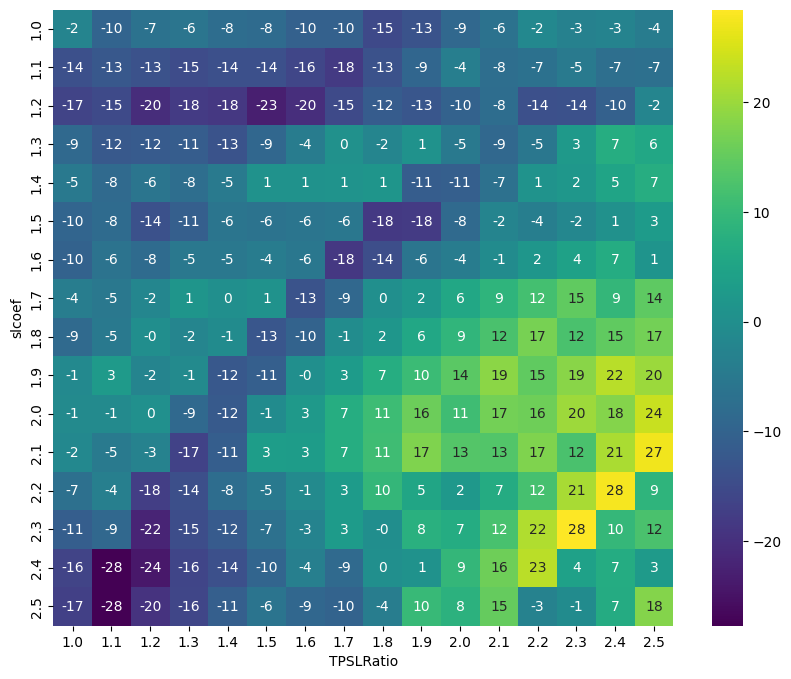

In [3]:
# Nasdaq index, 1 year period 1 hour interval
# Use MACD to generate trade signals

def total_trade_signal(row):
    if (row.MACD_trade_signal == 1):
        return 1
    elif (row.MACD_trade_signal == -1):
        return -1
    else:
        return 0


tradingData = read_data('^ixic', '1y', '1h')
set_indicators(tradingData, 200)
set_trade_signals(tradingData, total_trade_signal)
stats, heatmap = backtest_trading(tradingData, 25000)

print(stats)
show_heatmap(heatmap)


In [27]:
data = ta.adx(tradingData['High'], tradingData['Low'], tradingData['Close'], length=14)
data

ADX_14    DMP_14     DMN_14
0           NaN       NaN        NaN
1           NaN       NaN        NaN
2           NaN       NaN        NaN
3           NaN       NaN        NaN
4           NaN       NaN        NaN
...         ...       ...        ...
1751  45.207414  8.977143  45.769877
1752  46.782486  8.327396  42.540009
1753  47.781023  9.446092  38.701594
1754  49.037578  8.788504  41.972180
1755  50.253773  8.307272  40.651621

[1756 rows x 3 columns]

100%|██████████| 1756/1756 [00:00<00:00, 92168.66it/s]

number of trades: 84



/var/folders/rk/xympl3kj42nf5b5zvnt_lrxh0000gn/T/ipykernel_14450/1086755232.py:158: UserWarning: Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.
  backtest = Backtest(data, MacdStrategy, cash=cash, margin=1/30, commission=0.00)
/Users/andrew/.pyenv/versions/3.11.4/lib/python3.11/site-packages/backtesting/backtesting.py:1375: UserWarning: For multiprocessing support in `Backtest.optimize()` set multiprocessing start method to 'fork'.
  warnings.warn("For multiprocessing support in `Backtest.optimize()` "


  0%|          | 0/8 [00:00<?, ?it/s]

Start                                     0.0
End                                    1755.0
Duration                               1755.0
Exposure Time [%]                   51.537585
Equity Final [$]                 33997.394965
Equity Peak [$]                  34646.399561
Return [%]                           35.98958
Buy & Hold Return [%]               26.184365
Return (Ann.) [%]                         0.0
Volatility (Ann.) [%]                     NaN
Sharpe Ratio                              NaN
Sortino Ratio                             NaN
Calmar Ratio                              0.0
Max. Drawdown [%]                   -9.469598
Avg. Drawdown [%]                   -1.132133
Max. Drawdown Duration                  649.0
Avg. Drawdown Duration                   30.8
# Trades                                 41.0
Win Rate [%]                        51.219512
Best Trade [%]                       3.233782
Worst Trade [%]                     -2.213789
Avg. Trade [%]                    

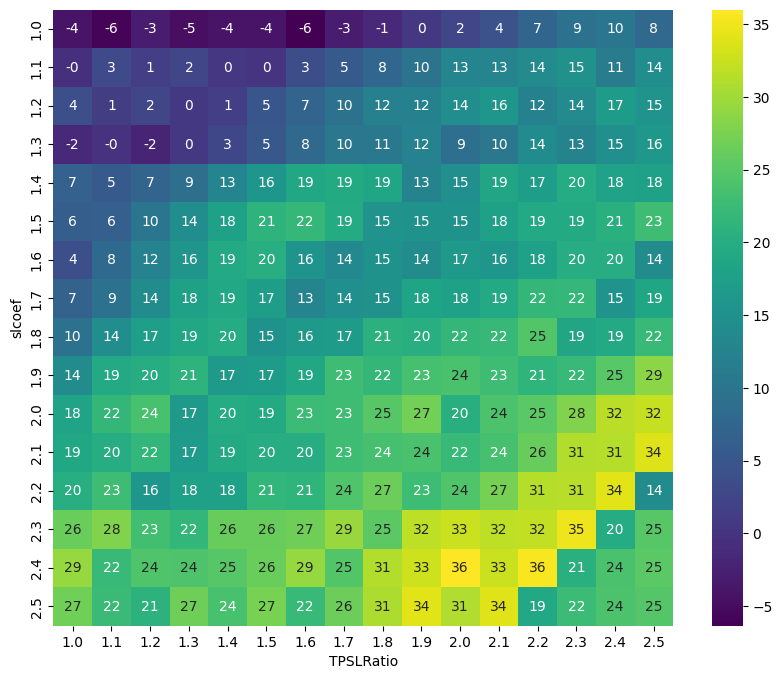

In [9]:
# Nasdaq index, 1 year period 1 hour interval
# Use MACD and EMA to generate trade signals

def total_trade_signal(row):
    if (row.EMA_trade_signal == 1 & row.MACD_trade_signal == 1):
        return 1
    elif (row.EMA_trade_signal == -1 & row.MACD_trade_signal == -1):
        return -1
    else:
        return 0

tradingData = read_data('^ixic', '1y', '1h')
set_indicators(tradingData, 200)
set_trade_signals(tradingData, total_trade_signal)
stats, heatmap = backtest_trading(tradingData, 25000)

print(stats)
show_heatmap(heatmap)


100%|██████████| 1756/1756 [00:00<00:00, 91966.11it/s]

number of trades: 10



/var/folders/rk/xympl3kj42nf5b5zvnt_lrxh0000gn/T/ipykernel_14450/4187898037.py:158: UserWarning: Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.
  backtest = Backtest(data, MacdStrategy, cash=cash, margin=1/30, commission=0.00)
/Users/andrew/.pyenv/versions/3.11.4/lib/python3.11/site-packages/backtesting/backtesting.py:1375: UserWarning: For multiprocessing support in `Backtest.optimize()` set multiprocessing start method to 'fork'.
  warnings.warn("For multiprocessing support in `Backtest.optimize()` "


  0%|          | 0/8 [00:00<?, ?it/s]

Start                                     0.0
End                                    1755.0
Duration                               1755.0
Exposure Time [%]                   10.307517
Equity Final [$]                 27841.847172
Equity Peak [$]                  28264.491796
Return [%]                          11.367389
Buy & Hold Return [%]               26.184365
Return (Ann.) [%]                         0.0
Volatility (Ann.) [%]                     NaN
Sharpe Ratio                              NaN
Sortino Ratio                             NaN
Calmar Ratio                              0.0
Max. Drawdown [%]                   -5.074485
Avg. Drawdown [%]                   -1.024723
Max. Drawdown Duration                  718.0
Avg. Drawdown Duration                   71.0
# Trades                                  9.0
Win Rate [%]                        55.555556
Best Trade [%]                       2.597066
Worst Trade [%]                      -1.52593
Avg. Trade [%]                    

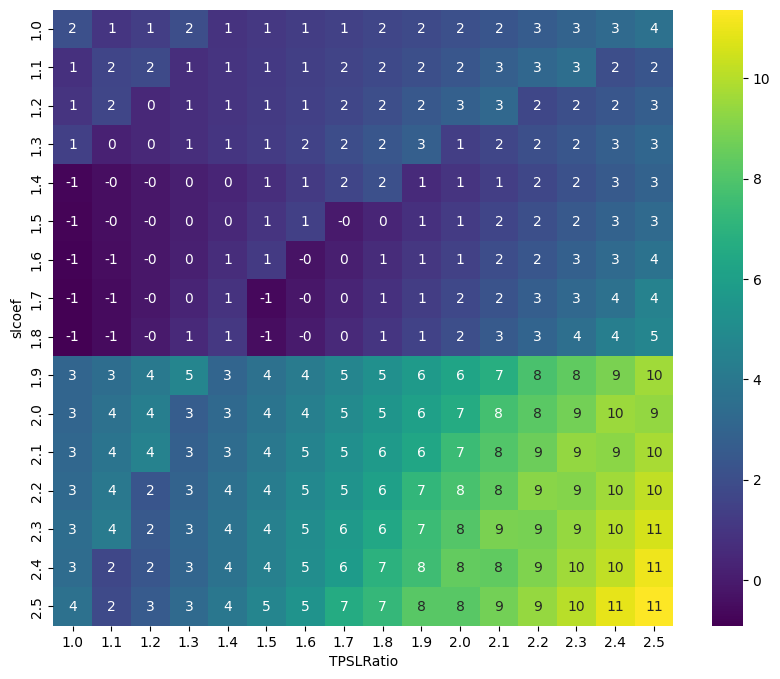

In [19]:
# Nasdaq index, 1 year period 1 hour interval
# Use MACD and RSI to generate trade signals

def total_trade_signal(row):
    if (row.RSI_trade_signal == 1 & row.MACD_trade_signal == 1):
        return 1
    elif (row.RSI_trade_signal == -1 & row.MACD_trade_signal == -1):
        return -1
    else:
        return 0

tradingData = read_data('^ixic', '1y', '1h')
set_indicators(tradingData, 200)
set_trade_signals(tradingData, total_trade_signal)
stats, heatmap = backtest_trading(tradingData, 25000)

print(stats)
show_heatmap(heatmap)


In [25]:
# Nasdaq index, 1 year period 1 hour interval
# Use MACD and ADX to generate trade signals

def total_trade_signal(row):
    if (row.ADX_trade_signal == 0):
        return 0

    if (row.MACD_trade_signal == 1):
        return 1
    elif (row.MACD_trade_signal == -1):
        return -1
    else:
        return 0

tradingData = read_data('^ixic', '1y', '1h')
set_indicators(tradingData, 200)
set_trade_signals(tradingData, total_trade_signal)
stats, heatmap = backtest_trading(tradingData, 25000)

print(stats)
show_heatmap(heatmap)


ValueError: Cannot set a DataFrame with multiple columns to the single column ADX

100%|██████████| 6120/6120 [00:00<00:00, 95053.29it/s]
/var/folders/rk/xympl3kj42nf5b5zvnt_lrxh0000gn/T/ipykernel_14450/4187898037.py:158: UserWarning: Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.
  backtest = Backtest(data, MacdStrategy, cash=cash, margin=1/30, commission=0.00)


number of trades: 214


/Users/andrew/.pyenv/versions/3.11.4/lib/python3.11/site-packages/backtesting/backtesting.py:1375: UserWarning: For multiprocessing support in `Backtest.optimize()` set multiprocessing start method to 'fork'.
  warnings.warn("For multiprocessing support in `Backtest.optimize()` "


  0%|          | 0/8 [00:00<?, ?it/s]

Start                                     0.0
End                                    6119.0
Duration                               6119.0
Exposure Time [%]                   21.568627
Equity Final [$]                 25000.206971
Equity Peak [$]                  25000.206971
Return [%]                           0.000828
Buy & Hold Return [%]               -0.665267
Return (Ann.) [%]                         0.0
Volatility (Ann.) [%]                     NaN
Sharpe Ratio                              NaN
Sortino Ratio                             NaN
Calmar Ratio                              0.0
Max. Drawdown [%]                   -0.000291
Avg. Drawdown [%]                   -0.000042
Max. Drawdown Duration                 1883.0
Avg. Drawdown Duration             116.869565
# Trades                                187.0
Win Rate [%]                        51.871658
Best Trade [%]                        0.37554
Worst Trade [%]                     -0.362438
Avg. Trade [%]                    

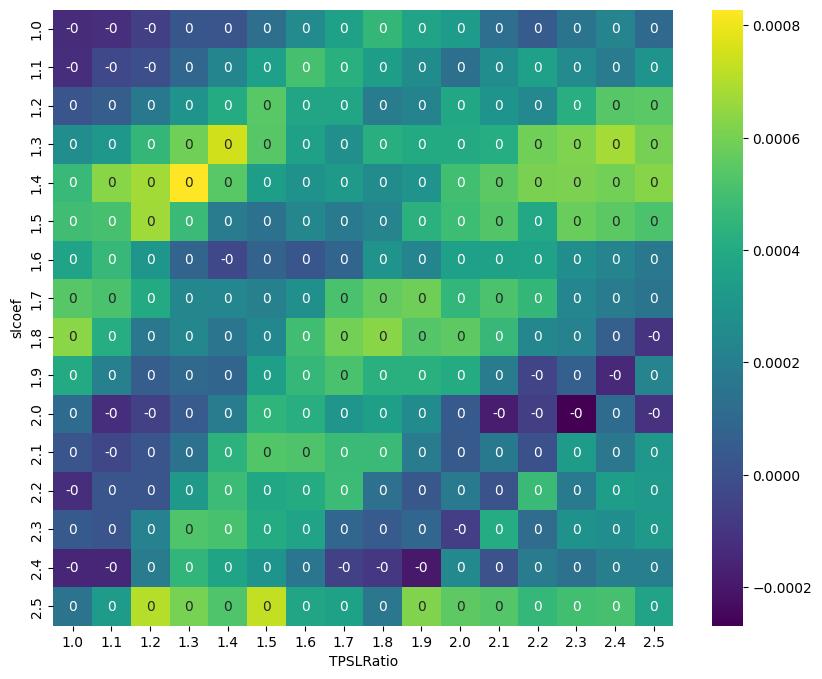

In [20]:
# GBPUSD, 1 year period 1 hour interval
# Use MACD and EMA to generate trade signals

def total_trade_signal(row):
    if (row.EMA_trade_signal == 1 & row.MACD_trade_signal == 1):
        return 1
    elif (row.EMA_trade_signal == -1 & row.MACD_trade_signal == -1):
        return -1
    else:
        return 0

tradingData = read_data('gbpusd=x', '1y', '1h')
set_indicators(tradingData, 200)
set_trade_signals(tradingData, total_trade_signal)
stats, heatmap = backtest_trading(tradingData, 25000)

print(stats)
show_heatmap(heatmap)


100%|██████████| 6120/6120 [00:00<00:00, 99290.75it/s]
/var/folders/rk/xympl3kj42nf5b5zvnt_lrxh0000gn/T/ipykernel_14450/4187898037.py:158: UserWarning: Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.
  backtest = Backtest(data, MacdStrategy, cash=cash, margin=1/30, commission=0.00)


number of trades: 31


/Users/andrew/.pyenv/versions/3.11.4/lib/python3.11/site-packages/backtesting/backtesting.py:1375: UserWarning: For multiprocessing support in `Backtest.optimize()` set multiprocessing start method to 'fork'.
  warnings.warn("For multiprocessing support in `Backtest.optimize()` "


  0%|          | 0/8 [00:00<?, ?it/s]

Start                                     0.0
End                                    6119.0
Duration                               6119.0
Exposure Time [%]                   12.009804
Equity Final [$]                 25000.045533
Equity Peak [$]                  25000.064284
Return [%]                           0.000182
Buy & Hold Return [%]               -0.665267
Return (Ann.) [%]                         0.0
Volatility (Ann.) [%]                     NaN
Sharpe Ratio                              NaN
Sortino Ratio                             NaN
Calmar Ratio                              0.0
Max. Drawdown [%]                   -0.000324
Avg. Drawdown [%]                   -0.000058
Max. Drawdown Duration                 3456.0
Avg. Drawdown Duration                  275.2
# Trades                                 30.0
Win Rate [%]                             50.0
Best Trade [%]                       0.618122
Worst Trade [%]                     -0.573711
Avg. Trade [%]                    

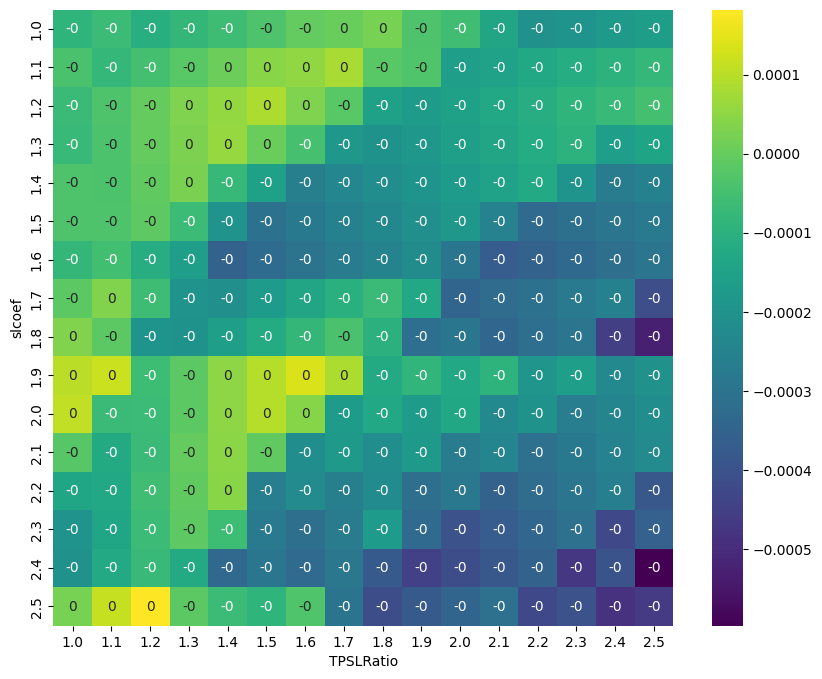

In [21]:
# GBPUSD, 1 year period 1 hour interval
# Use MACD and RSI to generate trade signals

def total_trade_signal(row):
    if (row.RSI_trade_signal == 1 & row.MACD_trade_signal == 1):
        return 1
    elif (row.RSI_trade_signal == -1 & row.MACD_trade_signal == -1):
        return -1
    else:
        return 0

tradingData = read_data('gbpusd=x', '1y', '1h')
set_indicators(tradingData, 200)
set_trade_signals(tradingData, total_trade_signal)
stats, heatmap = backtest_trading(tradingData, 25000)

print(stats)
show_heatmap(heatmap)


100%|██████████| 6120/6120 [00:00<00:00, 163671.81it/s]
/var/folders/rk/xympl3kj42nf5b5zvnt_lrxh0000gn/T/ipykernel_74906/387044617.py:146: UserWarning: Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.
  backtest = Backtest(data, MacdStrategy, cash=cash, margin=1/30, commission=0.00)


number of trades: 421


/Users/andrew/.pyenv/versions/3.11.4/lib/python3.11/site-packages/backtesting/backtesting.py:1375: UserWarning: For multiprocessing support in `Backtest.optimize()` set multiprocessing start method to 'fork'.
  warnings.warn("For multiprocessing support in `Backtest.optimize()` "


  0%|          | 0/8 [00:00<?, ?it/s]

Start                                     0.0
End                                    6119.0
Duration                               6119.0
Exposure Time [%]                   39.526144
Equity Final [$]                 25000.191852
Equity Peak [$]                  25000.191852
Return [%]                           0.000767
Buy & Hold Return [%]               -0.665267
Return (Ann.) [%]                         0.0
Volatility (Ann.) [%]                     NaN
Sharpe Ratio                              NaN
Sortino Ratio                             NaN
Calmar Ratio                              0.0
Max. Drawdown [%]                    -0.00031
Avg. Drawdown [%]                   -0.000044
Max. Drawdown Duration                 2746.0
Avg. Drawdown Duration                140.225
# Trades                                341.0
Win Rate [%]                        53.665689
Best Trade [%]                        0.37554
Worst Trade [%]                     -0.449765
Avg. Trade [%]                    

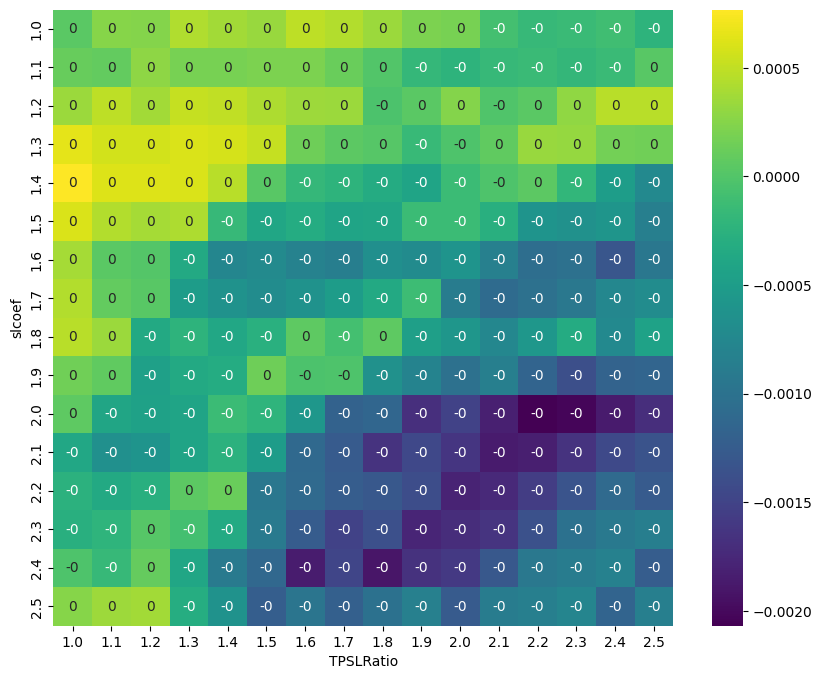

In [17]:
def total_trade_signal(row):
    if (row.MACD_trade_signal == 1):
        return 1
    elif (row.MACD_trade_signal == -1):
        return -1
    else:
        return 0

tradingData = read_data('gbpusd=x', '1y', '1h')
set_indicators(tradingData, 200)
set_trade_signals(tradingData, total_trade_signal)
backtest_trading(tradingData, 25000)

In [21]:
# All indices, 1 year period 1 hour interval
# Use MACD and EMA to generate trade signals

def total_trade_signal(row):
    if (row.EMA_trade_signal == 1 & row.MACD_trade_signal == 1):
        return 1
    elif (row.EMA_trade_signal == -1 & row.MACD_trade_signal == -1):
        return -1
    else:
        return 0


indices = ['^ixic', '^GSPC', '^DJI', '^NYA', '^BUK100P',
           '^RUT', '^VIX', '^FTSE', '^N225', '^HSI', '^GDAXI', '^FCHI']
return_stats = pd.DataFrame(
    columns=['Index', 'Buy & Hold Return [%]', 'Return [%]'])

for index in indices:
    tradingData = read_data(index, '1y', '1h')
    set_indicators(tradingData, 200)
    set_trade_signals(tradingData, total_trade_signal)
    stats, heatmap = backtest_trading(tradingData, 25000)

    return_stats = pd.concat([
        return_stats,
        pd.DataFrame([[index, stats.loc['Buy & Hold Return [%]'], stats.loc['Return [%]']]], columns=[
                     'Index', 'Buy & Hold Return [%]', 'Return [%]'])
    ], ignore_index=True)


return_stats

100%|██████████| 1756/1756 [00:00<00:00, 99078.49it/s]

number of trades: 84



/var/folders/rk/xympl3kj42nf5b5zvnt_lrxh0000gn/T/ipykernel_95933/3449451515.py:146: UserWarning: Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.
  backtest = Backtest(data, MacdStrategy, cash=cash, margin=1/30, commission=0.00)
/Users/andrew/.pyenv/versions/3.11.4/lib/python3.11/site-packages/backtesting/backtesting.py:1375: UserWarning: For multiprocessing support in `Backtest.optimize()` set multiprocessing start method to 'fork'.
  warnings.warn("For multiprocessing support in `Backtest.optimize()` "


  0%|          | 0/8 [00:00<?, ?it/s]

/var/folders/rk/xympl3kj42nf5b5zvnt_lrxh0000gn/T/ipykernel_95933/1418790553.py:21: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return_stats = pd.concat([
100%|██████████| 1749/1749 [00:00<00:00, 99732.69it/s]

number of trades: 76



/var/folders/rk/xympl3kj42nf5b5zvnt_lrxh0000gn/T/ipykernel_95933/3449451515.py:146: UserWarning: Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.
  backtest = Backtest(data, MacdStrategy, cash=cash, margin=1/30, commission=0.00)
/Users/andrew/.pyenv/versions/3.11.4/lib/python3.11/site-packages/backtesting/backtesting.py:1375: UserWarning: For multiprocessing support in `Backtest.optimize()` set multiprocessing start method to 'fork'.
  warnings.warn("For multiprocessing support in `Backtest.optimize()` "


  0%|          | 0/8 [00:00<?, ?it/s]

100%|██████████| 1749/1749 [00:00<00:00, 99887.50it/s]

number of trades: 73



/var/folders/rk/xympl3kj42nf5b5zvnt_lrxh0000gn/T/ipykernel_95933/3449451515.py:146: UserWarning: Some prices are larger than initial cash value. Note that fractional trading is not supported. If you want to trade Bitcoin, increase initial cash, or trade μBTC or satoshis instead (GH-134).
  backtest = Backtest(data, MacdStrategy, cash=cash, margin=1/30, commission=0.00)
/var/folders/rk/xympl3kj42nf5b5zvnt_lrxh0000gn/T/ipykernel_95933/3449451515.py:146: UserWarning: Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.
  backtest = Backtest(data, MacdStrategy, cash=cash, margin=1/30, commission=0.00)
/Users/andrew/.pyenv/versions/3.11.4/lib/python3.11/site-packages/backtesting/backtesting.py:1375: UserWarning: For multiprocessing support in `Backtest.optimize()` set multiprocessing start method to 'fork'.
  warnings.warn("For multiprocessing support in `Backtest.optimize()` "


  0%|          | 0/8 [00:00<?, ?it/s]

100%|██████████| 1749/1749 [00:00<00:00, 94685.29it/s]

number of trades: 77



/var/folders/rk/xympl3kj42nf5b5zvnt_lrxh0000gn/T/ipykernel_95933/3449451515.py:146: UserWarning: Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.
  backtest = Backtest(data, MacdStrategy, cash=cash, margin=1/30, commission=0.00)
/Users/andrew/.pyenv/versions/3.11.4/lib/python3.11/site-packages/backtesting/backtesting.py:1375: UserWarning: For multiprocessing support in `Backtest.optimize()` set multiprocessing start method to 'fork'.
  warnings.warn("For multiprocessing support in `Backtest.optimize()` "


  0%|          | 0/8 [00:00<?, ?it/s]

100%|██████████| 2261/2261 [00:00<00:00, 93156.40it/s]

number of trades: 90



/var/folders/rk/xympl3kj42nf5b5zvnt_lrxh0000gn/T/ipykernel_95933/3449451515.py:146: UserWarning: Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.
  backtest = Backtest(data, MacdStrategy, cash=cash, margin=1/30, commission=0.00)
/Users/andrew/.pyenv/versions/3.11.4/lib/python3.11/site-packages/backtesting/backtesting.py:1375: UserWarning: For multiprocessing support in `Backtest.optimize()` set multiprocessing start method to 'fork'.
  warnings.warn("For multiprocessing support in `Backtest.optimize()` "


  0%|          | 0/8 [00:00<?, ?it/s]

100%|██████████| 1749/1749 [00:00<00:00, 100689.55it/s]

number of trades: 65



/var/folders/rk/xympl3kj42nf5b5zvnt_lrxh0000gn/T/ipykernel_95933/3449451515.py:146: UserWarning: Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.
  backtest = Backtest(data, MacdStrategy, cash=cash, margin=1/30, commission=0.00)
/Users/andrew/.pyenv/versions/3.11.4/lib/python3.11/site-packages/backtesting/backtesting.py:1375: UserWarning: For multiprocessing support in `Backtest.optimize()` set multiprocessing start method to 'fork'.
  warnings.warn("For multiprocessing support in `Backtest.optimize()` "


  0%|          | 0/8 [00:00<?, ?it/s]

100%|██████████| 3551/3551 [00:00<00:00, 100011.91it/s]

number of trades: 123



/var/folders/rk/xympl3kj42nf5b5zvnt_lrxh0000gn/T/ipykernel_95933/3449451515.py:146: UserWarning: Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.
  backtest = Backtest(data, MacdStrategy, cash=cash, margin=1/30, commission=0.00)
/Users/andrew/.pyenv/versions/3.11.4/lib/python3.11/site-packages/backtesting/backtesting.py:1375: UserWarning: For multiprocessing support in `Backtest.optimize()` set multiprocessing start method to 'fork'.
  warnings.warn("For multiprocessing support in `Backtest.optimize()` "


  0%|          | 0/8 [00:00<?, ?it/s]

100%|██████████| 2258/2258 [00:00<00:00, 100561.04it/s]

number of trades: 82



/var/folders/rk/xympl3kj42nf5b5zvnt_lrxh0000gn/T/ipykernel_95933/3449451515.py:146: UserWarning: Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.
  backtest = Backtest(data, MacdStrategy, cash=cash, margin=1/30, commission=0.00)
/Users/andrew/.pyenv/versions/3.11.4/lib/python3.11/site-packages/backtesting/backtesting.py:1375: UserWarning: For multiprocessing support in `Backtest.optimize()` set multiprocessing start method to 'fork'.
  warnings.warn("For multiprocessing support in `Backtest.optimize()` "


  0%|          | 0/8 [00:00<?, ?it/s]

100%|██████████| 1470/1470 [00:00<00:00, 93014.12it/s]

number of trades: 55



/var/folders/rk/xympl3kj42nf5b5zvnt_lrxh0000gn/T/ipykernel_95933/3449451515.py:146: UserWarning: Some prices are larger than initial cash value. Note that fractional trading is not supported. If you want to trade Bitcoin, increase initial cash, or trade μBTC or satoshis instead (GH-134).
  backtest = Backtest(data, MacdStrategy, cash=cash, margin=1/30, commission=0.00)
/var/folders/rk/xympl3kj42nf5b5zvnt_lrxh0000gn/T/ipykernel_95933/3449451515.py:146: UserWarning: Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.
  backtest = Backtest(data, MacdStrategy, cash=cash, margin=1/30, commission=0.00)
/Users/andrew/.pyenv/versions/3.11.4/lib/python3.11/site-packages/backtesting/backtesting.py:1375: UserWarning: For multiprocessing support in `Backtest.optimize()` set multiprocessing start method to 'fork'.
  warnings.warn("For multiprocessing support in `Backtest.optimize()` "


  0%|          | 0/8 [00:00<?, ?it/s]

100%|██████████| 1706/1706 [00:00<00:00, 95328.90it/s]

number of trades: 40



/var/folders/rk/xympl3kj42nf5b5zvnt_lrxh0000gn/T/ipykernel_95933/3449451515.py:146: UserWarning: Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.
  backtest = Backtest(data, MacdStrategy, cash=cash, margin=1/30, commission=0.00)
/Users/andrew/.pyenv/versions/3.11.4/lib/python3.11/site-packages/backtesting/backtesting.py:1375: UserWarning: For multiprocessing support in `Backtest.optimize()` set multiprocessing start method to 'fork'.
  warnings.warn("For multiprocessing support in `Backtest.optimize()` "


  0%|          | 0/8 [00:00<?, ?it/s]

100%|██████████| 2291/2291 [00:00<00:00, 100973.58it/s]

number of trades: 95



/var/folders/rk/xympl3kj42nf5b5zvnt_lrxh0000gn/T/ipykernel_95933/3449451515.py:146: UserWarning: Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.
  backtest = Backtest(data, MacdStrategy, cash=cash, margin=1/30, commission=0.00)
/Users/andrew/.pyenv/versions/3.11.4/lib/python3.11/site-packages/backtesting/backtesting.py:1375: UserWarning: For multiprocessing support in `Backtest.optimize()` set multiprocessing start method to 'fork'.
  warnings.warn("For multiprocessing support in `Backtest.optimize()` "


  0%|          | 0/8 [00:00<?, ?it/s]

100%|██████████| 2295/2295 [00:00<00:00, 91324.12it/s]

number of trades: 87



/var/folders/rk/xympl3kj42nf5b5zvnt_lrxh0000gn/T/ipykernel_95933/3449451515.py:146: UserWarning: Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.
  backtest = Backtest(data, MacdStrategy, cash=cash, margin=1/30, commission=0.00)
/Users/andrew/.pyenv/versions/3.11.4/lib/python3.11/site-packages/backtesting/backtesting.py:1375: UserWarning: For multiprocessing support in `Backtest.optimize()` set multiprocessing start method to 'fork'.
  warnings.warn("For multiprocessing support in `Backtest.optimize()` "


  0%|          | 0/8 [00:00<?, ?it/s]

Index  Buy & Hold Return [%]  Return [%]
0      ^ixic              26.184365   35.989580
1      ^GSPC              20.992456    8.424473
2       ^DJI              12.867031   47.460622
3       ^NYA              12.727577   21.646052
4   ^BUK100P               1.394891   -0.194998
5       ^RUT               9.503821    5.839893
6       ^VIX              -6.253454    0.011407
7      ^FTSE               1.547797   -2.152672
8      ^N225              30.877396   27.477559
9       ^HSI             -17.553435    1.604216
10    ^GDAXI              12.515501   23.209907
11     ^FCHI               6.377608    1.638906

In [22]:
# All indices, 1 year period 1 hour interval
# Use MACD and RSI to generate trade signals

def total_trade_signal(row):
    if (row.EMA_trade_signal == 1 & row.MACD_trade_signal == 1):
        return 1
    elif (row.EMA_trade_signal == -1 & row.MACD_trade_signal == -1):
        return -1
    else:
        return 0


indices = ['^ixic', '^GSPC', '^DJI', '^NYA', '^BUK100P',
           '^RUT', '^VIX', '^FTSE', '^N225', '^HSI', '^GDAXI', '^FCHI']
return_stats = pd.DataFrame(
    columns=['Index', 'Buy & Hold Return [%]', 'Return [%]'])

for index in indices:
    tradingData = read_data(index, '1y', '1h')
    set_indicators(tradingData, 200)
    set_trade_signals(tradingData, total_trade_signal)
    stats, heatmap = backtest_trading(tradingData, 25000)

    return_stats = pd.concat([
        return_stats,
        pd.DataFrame([[index, stats.loc['Buy & Hold Return [%]'], stats.loc['Return [%]']]], columns=[
                     'Index', 'Buy & Hold Return [%]', 'Return [%]'])
    ], ignore_index=True)


return_stats

100%|██████████| 1756/1756 [00:00<00:00, 91932.82it/s]

number of trades: 84



/var/folders/rk/xympl3kj42nf5b5zvnt_lrxh0000gn/T/ipykernel_14450/4187898037.py:158: UserWarning: Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.
  backtest = Backtest(data, MacdStrategy, cash=cash, margin=1/30, commission=0.00)
/Users/andrew/.pyenv/versions/3.11.4/lib/python3.11/site-packages/backtesting/backtesting.py:1375: UserWarning: For multiprocessing support in `Backtest.optimize()` set multiprocessing start method to 'fork'.
  warnings.warn("For multiprocessing support in `Backtest.optimize()` "


  0%|          | 0/8 [00:00<?, ?it/s]

/var/folders/rk/xympl3kj42nf5b5zvnt_lrxh0000gn/T/ipykernel_14450/3878832993.py:24: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return_stats = pd.concat([
100%|██████████| 1749/1749 [00:00<00:00, 99122.23it/s]

number of trades: 76



/var/folders/rk/xympl3kj42nf5b5zvnt_lrxh0000gn/T/ipykernel_14450/4187898037.py:158: UserWarning: Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.
  backtest = Backtest(data, MacdStrategy, cash=cash, margin=1/30, commission=0.00)
/Users/andrew/.pyenv/versions/3.11.4/lib/python3.11/site-packages/backtesting/backtesting.py:1375: UserWarning: For multiprocessing support in `Backtest.optimize()` set multiprocessing start method to 'fork'.
  warnings.warn("For multiprocessing support in `Backtest.optimize()` "


  0%|          | 0/8 [00:00<?, ?it/s]

100%|██████████| 1749/1749 [00:00<00:00, 93905.93it/s]

number of trades: 73



/var/folders/rk/xympl3kj42nf5b5zvnt_lrxh0000gn/T/ipykernel_14450/4187898037.py:158: UserWarning: Some prices are larger than initial cash value. Note that fractional trading is not supported. If you want to trade Bitcoin, increase initial cash, or trade μBTC or satoshis instead (GH-134).
  backtest = Backtest(data, MacdStrategy, cash=cash, margin=1/30, commission=0.00)
/var/folders/rk/xympl3kj42nf5b5zvnt_lrxh0000gn/T/ipykernel_14450/4187898037.py:158: UserWarning: Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.
  backtest = Backtest(data, MacdStrategy, cash=cash, margin=1/30, commission=0.00)
/Users/andrew/.pyenv/versions/3.11.4/lib/python3.11/site-packages/backtesting/backtesting.py:1375: UserWarning: For multiprocessing support in `Backtest.optimize()` set multiprocessing start method to 'fork'.
  warnings.warn("For multiprocessing support in `Backtest.optimize()` "


  0%|          | 0/8 [00:00<?, ?it/s]

100%|██████████| 1749/1749 [00:00<00:00, 90657.67it/s]

number of trades: 77



/var/folders/rk/xympl3kj42nf5b5zvnt_lrxh0000gn/T/ipykernel_14450/4187898037.py:158: UserWarning: Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.
  backtest = Backtest(data, MacdStrategy, cash=cash, margin=1/30, commission=0.00)
/Users/andrew/.pyenv/versions/3.11.4/lib/python3.11/site-packages/backtesting/backtesting.py:1375: UserWarning: For multiprocessing support in `Backtest.optimize()` set multiprocessing start method to 'fork'.
  warnings.warn("For multiprocessing support in `Backtest.optimize()` "


  0%|          | 0/8 [00:00<?, ?it/s]

100%|██████████| 2261/2261 [00:00<00:00, 89857.79it/s]

number of trades: 90



/var/folders/rk/xympl3kj42nf5b5zvnt_lrxh0000gn/T/ipykernel_14450/4187898037.py:158: UserWarning: Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.
  backtest = Backtest(data, MacdStrategy, cash=cash, margin=1/30, commission=0.00)
/Users/andrew/.pyenv/versions/3.11.4/lib/python3.11/site-packages/backtesting/backtesting.py:1375: UserWarning: For multiprocessing support in `Backtest.optimize()` set multiprocessing start method to 'fork'.
  warnings.warn("For multiprocessing support in `Backtest.optimize()` "


  0%|          | 0/8 [00:00<?, ?it/s]

100%|██████████| 1749/1749 [00:00<00:00, 90698.03it/s]

number of trades: 65



/var/folders/rk/xympl3kj42nf5b5zvnt_lrxh0000gn/T/ipykernel_14450/4187898037.py:158: UserWarning: Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.
  backtest = Backtest(data, MacdStrategy, cash=cash, margin=1/30, commission=0.00)
/Users/andrew/.pyenv/versions/3.11.4/lib/python3.11/site-packages/backtesting/backtesting.py:1375: UserWarning: For multiprocessing support in `Backtest.optimize()` set multiprocessing start method to 'fork'.
  warnings.warn("For multiprocessing support in `Backtest.optimize()` "


  0%|          | 0/8 [00:00<?, ?it/s]

100%|██████████| 3551/3551 [00:00<00:00, 83419.06it/s]

number of trades: 123



/var/folders/rk/xympl3kj42nf5b5zvnt_lrxh0000gn/T/ipykernel_14450/4187898037.py:158: UserWarning: Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.
  backtest = Backtest(data, MacdStrategy, cash=cash, margin=1/30, commission=0.00)
/Users/andrew/.pyenv/versions/3.11.4/lib/python3.11/site-packages/backtesting/backtesting.py:1375: UserWarning: For multiprocessing support in `Backtest.optimize()` set multiprocessing start method to 'fork'.
  warnings.warn("For multiprocessing support in `Backtest.optimize()` "


  0%|          | 0/8 [00:00<?, ?it/s]

100%|██████████| 2258/2258 [00:00<00:00, 86917.01it/s]
/var/folders/rk/xympl3kj42nf5b5zvnt_lrxh0000gn/T/ipykernel_14450/4187898037.py:158: UserWarning: Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.
  backtest = Backtest(data, MacdStrategy, cash=cash, margin=1/30, commission=0.00)


number of trades: 82


/Users/andrew/.pyenv/versions/3.11.4/lib/python3.11/site-packages/backtesting/backtesting.py:1375: UserWarning: For multiprocessing support in `Backtest.optimize()` set multiprocessing start method to 'fork'.
  warnings.warn("For multiprocessing support in `Backtest.optimize()` "


  0%|          | 0/8 [00:00<?, ?it/s]

100%|██████████| 1470/1470 [00:00<00:00, 74995.77it/s]

number of trades: 55



/var/folders/rk/xympl3kj42nf5b5zvnt_lrxh0000gn/T/ipykernel_14450/4187898037.py:158: UserWarning: Some prices are larger than initial cash value. Note that fractional trading is not supported. If you want to trade Bitcoin, increase initial cash, or trade μBTC or satoshis instead (GH-134).
  backtest = Backtest(data, MacdStrategy, cash=cash, margin=1/30, commission=0.00)
/var/folders/rk/xympl3kj42nf5b5zvnt_lrxh0000gn/T/ipykernel_14450/4187898037.py:158: UserWarning: Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.
  backtest = Backtest(data, MacdStrategy, cash=cash, margin=1/30, commission=0.00)
/Users/andrew/.pyenv/versions/3.11.4/lib/python3.11/site-packages/backtesting/backtesting.py:1375: UserWarning: For multiprocessing support in `Backtest.optimize()` set multiprocessing start method to 'fork'.
  warnings.warn("For multiprocessing support in `Backtest.optimize()` "


  0%|          | 0/8 [00:00<?, ?it/s]

100%|██████████| 1706/1706 [00:00<00:00, 78378.45it/s]
/var/folders/rk/xympl3kj42nf5b5zvnt_lrxh0000gn/T/ipykernel_14450/4187898037.py:158: UserWarning: Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.
  backtest = Backtest(data, MacdStrategy, cash=cash, margin=1/30, commission=0.00)


number of trades: 40


/Users/andrew/.pyenv/versions/3.11.4/lib/python3.11/site-packages/backtesting/backtesting.py:1375: UserWarning: For multiprocessing support in `Backtest.optimize()` set multiprocessing start method to 'fork'.
  warnings.warn("For multiprocessing support in `Backtest.optimize()` "


  0%|          | 0/8 [00:00<?, ?it/s]

100%|██████████| 2291/2291 [00:00<00:00, 87090.68it/s]

number of trades: 95



/var/folders/rk/xympl3kj42nf5b5zvnt_lrxh0000gn/T/ipykernel_14450/4187898037.py:158: UserWarning: Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.
  backtest = Backtest(data, MacdStrategy, cash=cash, margin=1/30, commission=0.00)
/Users/andrew/.pyenv/versions/3.11.4/lib/python3.11/site-packages/backtesting/backtesting.py:1375: UserWarning: For multiprocessing support in `Backtest.optimize()` set multiprocessing start method to 'fork'.
  warnings.warn("For multiprocessing support in `Backtest.optimize()` "


  0%|          | 0/8 [00:00<?, ?it/s]

100%|██████████| 2295/2295 [00:00<00:00, 49611.02it/s]
/var/folders/rk/xympl3kj42nf5b5zvnt_lrxh0000gn/T/ipykernel_14450/4187898037.py:158: UserWarning: Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.
  backtest = Backtest(data, MacdStrategy, cash=cash, margin=1/30, commission=0.00)


number of trades: 87


/Users/andrew/.pyenv/versions/3.11.4/lib/python3.11/site-packages/backtesting/backtesting.py:1375: UserWarning: For multiprocessing support in `Backtest.optimize()` set multiprocessing start method to 'fork'.
  warnings.warn("For multiprocessing support in `Backtest.optimize()` "


  0%|          | 0/8 [00:00<?, ?it/s]

Index  Buy & Hold Return [%]  Return [%]
0      ^ixic              26.184365   35.989580
1      ^GSPC              20.992456    8.424473
2       ^DJI              12.867031   47.460622
3       ^NYA              12.727577   21.646052
4   ^BUK100P               1.394891   -0.194998
5       ^RUT               9.503821    5.839893
6       ^VIX              -6.253454    0.011407
7      ^FTSE               1.547797   -2.152672
8      ^N225              30.877396   27.477559
9       ^HSI             -17.553435    1.604216
10    ^GDAXI              12.515501   23.209907
11     ^FCHI               6.377608    1.638906